In [1]:
from scipy.optimize import fsolve
import numpy as np
from docplex.mp.model import Model
import matplotlib.pyplot as plt
import random
from numpy.linalg import eig
# from control import matlab
from control import dlqr
# from scipy.signal import place_poles
from scipy.io import savemat

In [2]:
# Define variables
Ca0=4
rho=1000
Cp=0.231
F=5
V=1
delH=-1.15*10**4
E=5*10**4
T0=300
k0=8.46*10**6
Rc=8.314

In [3]:
# Solve for Ca, T
def ss(p):
    Ca, T = p
    e1=(F/V)*(Ca0-Ca)-k0*np.exp(-E/(Rc*T))*Ca**2
    e2=(F/V)*(T0-T)-(delH*k0/(rho*Cp))*np.exp(-E/(Rc*T))*Ca**2
    return (e1, e2)

CAs, Ts =  fsolve(ss, (1,400))
print(CAs,Ts)

1.2230500795162234 438.24642461282866


In [4]:
# a11=0.7364
# a12=-0.0041
# a21=10.6953
# a22=1.1560
# b1=-9.0708*10**-8
# b2=4.6741*10**-5
# g1=1.0513
# g2=1.0513


In [5]:
a11 = - (F/V) -2*k0*np.exp(-E/(Rc*(Ts)))*(CAs)
a12 = - k0*( (CAs)**2 )*np.exp(-E/(Rc*(Ts)))*(E/(Rc*(Ts)**2))
a21 = - 2* (CAs)*((delH*k0)/(rho*Cp)) * np.exp(-E/(Rc*(Ts)))
a22 = - (F/V) - ((delH*k0*( (CAs)**2 ))/(rho*Cp)) * np.exp(-E/(Rc*(Ts)))*(E/(Rc*(Ts)**2))
b1  = 0
b2  = 1/(rho*Cp*V)
g11 = F/V
g12 = 0
g21 = 0
g22 = F/V

In [6]:
# Define the LQR system matrices
A_c=np.array([[a11,a12],[a21,a22]])
B_c=np.array([[b1],[b2]])
C_d = np.array([[1, 0], [0, 1]])
D = np.array([[0],[0]])
E_c = np.array([[g11, g12], [g21, g22]])
# w,v=eig(A)
# print(B)

In [7]:
# Compute the values of Discretized A,B,C
# sys = matlab.ss(A_c, B_c, C_c, D)
# Tos=0.01
# sys1= matlab.c2d(sys, Tos, method='zoh')

# A_d=sys1.A
# B_d=sys1.B
# C_d=sys1.C
# print(A_d)
# print(B_d)
# print(Q)


In [8]:
##### Define the decision variables and control inputs

num_states,num_control_inputs = B_c.shape                                       # Number of states 
num_outputs = len(C_d)
num_steps = 300                                                                   # Prediction horizon
tot_time =300                                                                   # Real time
sample_period = 0.01  
# # x0 = np.array([[0.1]])
x0 = np.array([[0.0], [0.0]])
# cost1=0

In [9]:
# Continuous-time to discrete-time conversion (FUNCTION)
from typing import Tuple
import numpy as np
from scipy.linalg import expm
def c2d(
    a_c: np.ndarray, b_c: np.ndarray, step_size: float
    ) -> Tuple[np.ndarray]:
    """
    Continuous to discrete conversion of A and B given a sample period
    Args:
         a_c (np.ndarray): A matrix
         b_c (np.ndarray): B matrix
         step_size (float): Sample period
    Returns:
        :obj:`tuple` of :obj:`np.ndarray`: matrix pair (Ad, Bd)
    """
    (n_x, n_u) = b_c.shape
    phi = np.concatenate(
        [np.concatenate([a_c, b_c], axis=1), np.zeros([n_u, n_x + n_u])],
        axis=0,
        )
    phi = expm(phi * step_size)
    return (phi[:n_x, :n_x], phi[:n_x, n_x:(n_x + n_u)])

In [10]:
# Continuous-time to discrete-time conversion (FUNCTION)
## Exact method discretization (Second approach)
step_size = 0.01    # in second
A_d = np.zeros((num_states,num_states))
B_d = np.zeros((num_states, num_control_inputs))
E_d = np.zeros((num_states, num_states))
BcEc = np.hstack((B_c, E_c))
BdEd = np.zeros((num_states,num_control_inputs+num_states))
# for i in range(num_steps):
#     A_c [:,:,i] = np.array(A_c [:,:,i])
#     B_c [:,:,i] = np.array(B_c [:,:,i])
#     E_c [:,:,i] = np.array(E_c [:,:,i])
#     BcEc [:,:,i] = np.hstack((B_c[:,:,i], E_c[:,:,i]))
# Get the dimensions of B_c and C_c
n_x, n_u = B_c.shape
A_d, BdEd  = c2d(A_c , BcEc , sample_period)
# Extract the discrete B_c and C_c from BdCd
B_d [:,:] = BdEd[:, :n_u]
E_d [:,:] = BdEd[:, n_u:]
# Calculate the eigenvalues
eigenvalues = np.linalg.eigvals(A_d)
# Print the eigenvalues
print("Eigenvalues of matrix A_d are:")
print(eigenvalues)
print ("A_d:")
print (A_d)
print ("B_d:")
print (B_d)
print ("E_d:")
print (np.shape(E_d))

Eigenvalues of matrix A_d are:
[0.94119361 0.95122942]
A_d:
[[ 7.36392975e-01 -4.11382138e-03]
 [ 1.06953211e+01  1.15603006e+00]]
B_d:
[[-9.07079550e-08]
 [ 4.67413705e-05]]
E_d:
(2, 2)


In [11]:
# Q = np.array([[4e+8, 0], [0, 7e+6]])        # State cost matrix
Q = np.array([[5e+8, 0], [0, 2e+10]])        # State cost matrix
# # Q = np.array([[4.91368059e+10, 0], [0, 1.87123559e+08]])
R = np.array([[1]])                                      # Control cost matrix
S = np.array([[0,0],[0,0]])

In [ ]:
K, S, Va = dlqr(A_d, B_d, Q, R)
# P1=np.array([-0.8,-0.85])
# P2=np.array([-0.2,-0.3])
# K=place_poles(A_d, B_d, P1, method='YT').gain_matrix
# L = np.transpose(place_poles(A.T, C.T, P2).gain_matrix)
# K = np.array([[-17968966.37029428],[45195.24611119]]).T
# At = np.array([[0.6, 0], [0, 1.3]])
At = np.array([[1, 0], [0,1]])
w,v=eig(A_d-B_d@K@At)
print(abs(w))
# print(abs(w))

[0.94119357 0.95122946]


In [40]:
# Initialize = Q  # Final costP matrix for each time step
P = np.zeros((Q.shape[0], Q.shape[1], tot_time+1))
P[:, :, num_steps] 

array([[0., 0.],
       [0., 0.]])

In [41]:
# # Backward recursion to compute P matrix
# for t in range(tot_time-1, -1, -1):
#     P[:, :, t] = Q + A_d.T @ P[:, :, t+1] @ A_d - A_d.T @ P[:, :, t+1] @ B_d @ np.linalg.inv(R + B_d.T @ P[:, :, t+1] @ B_d) @ B_d.T @ P[:, :, t+1] @ A_d

# # Compute optimal control gain matrix K
# K = np.zeros((B_d.shape[1], A_d.shape[0], tot_time))
# for t in range(tot_time):
#     K[:, :, t] = np.linalg.inv(R + B_d.T @ P[:, :, t+1] @ B_d) @ B_d.T @ P[:, :, t+1] @ A_d

In [42]:
steps=int(sample_period/step_size)

In [43]:
alpha1=0.01
alpha2=0.2

In [44]:
##### Store the states, outputs and controls for plotting (I have replaced tot_time with num_steps for the building model)

states = np.zeros((num_states, tot_time+1))
all_states = np.zeros((num_states, steps*tot_time+1))
output = np.zeros((num_outputs, tot_time+1))
all_outputs = np.zeros((num_outputs, steps*tot_time+1))
dist_ol = np.zeros((num_states, tot_time+1))
controls = np.zeros((num_control_inputs, tot_time+1))
rate_MPC = np.zeros((tot_time+1))
tot_cost_MPC = np.zeros((tot_time+1))
dist_MPC = np.zeros([4,tot_time+1])
norm_x = np.zeros((tot_time+1))
norm_y = np.zeros((tot_time+1))

In [45]:
##### Closed-loop MPC    
random.seed(0)
for n in range(tot_time):
    print('Time step:',n)
    mpc = Model()
    
    # Define the bounds for each state
    lower_bounds = [-1, -5] 
    upper_bounds = [1, 5]    

   
    # x_var = np.array([[mpc.continuous_var(name=f"x_var{i}_{j}",lb=-mpc.infinity) for j in range(num_steps+1)] for i in range(num_states)])
    x_var = np.array([[mpc.continuous_var(name=f"x_var{i}_{j}",lb=lower_bounds[i], ub=upper_bounds[i]) for j in range(num_steps+1)] for i in range(num_states)])
    u_var = np.array([[mpc.continuous_var(name=f"u_var{i}_{j}",lb=-20000,ub=20000 ) for j in range(num_steps)] for i in range(num_control_inputs)])

    #### Open-loop MPC

    # ### Define disturbances and noise
    
    dist_1=random.uniform(-alpha1, alpha1)                                            # Disturbance in state 1
    dist_2=random.uniform(-alpha2, alpha2)                                            # Disturbance in state 2
    # d=[[dist_1]]
    d=np.array([[dist_1],[dist_2]])
    for i in range(num_steps):
        dist_ol[0,i]=dist_1
        dist_ol[1,i]=dist_2
    noise_1=random.uniform(-alpha1, alpha1)
    noise_2=random.uniform(-alpha2, alpha2)
    noise=[[noise_1],[noise_2]]
    # noise=[[noise_1]]
    dist_MPC[:,n] = [dist_1,dist_2,noise_1,noise_2]

    ### Add the state space equations as contraints
    for i in range(num_steps):
        for m in range (num_states):
            ## Create the state space equations
            state_eq = mpc.sum(A_d[m, j] * x_var[j, i] for j in range(num_states))
            control_eq = mpc.sum(B_d[m, k] * u_var[k, i] for k in range(num_control_inputs))
            # terminal_eq = mpc.sum(E_d[m,l] * dist_ol[l,i] for l in range(num_states))

            ## Add the constraint for the current time step
            mpc.add_constraint(x_var[m, i + 1] == state_eq + control_eq)

    ### Initial condition
    y0 = At @ (C_d @ x0 + noise)
    mpc.add_constraint(x_var[0,0] == y0[0,0])
    mpc.add_constraint(x_var[1,0] == y0[1,0])

    ### Create the objective expression 
    J = []
    for i in range(num_steps):
        state_cost = 0
        input_cost = 0
        for m in range(num_states):
            state_cost += mpc.sum(x_var[m,i] * Q[m,j] * x_var[j,i] for j in range(num_states))
        for m in range(num_control_inputs):
            input_cost += mpc.sum(u_var[m,i] * R[m,j] * u_var[j,i] for j in range(num_control_inputs))
        J.append(state_cost + input_cost) 
    # Terminal cost calculation
    terminal_cost = 0
    for m in range(num_states):
        terminal_cost += mpc.sum(x_var[m, num_steps] * S[m, j] * x_var[j, num_steps] for j in range(num_states))
    J.append(terminal_cost)
    ### Set the objective sense and expression in the model
    objective = mpc.sum(J[j]   for j in range(num_steps))
    # print(objective)
    mpc.set_objective("minimize", objective)

    ### Solve the model
    solution_tot = mpc.solve()
    # mpc.print_information()
    # print(mpc.solve_details)
    # print(solution_tot)

    # Check if the solution was successful (non-empty)
    if not solution_tot:
        n=n-2
    # if the optimization is infeasible, the loop will break. After the break the x0 value assigned in states will have no use as that is already done. Also, in plotting only n-1 states willbe printed
        print("Solution not found. Exiting loop.")
        break
       
    ### Extract the values for X and U from the solution
    X_values = np.array([[solution_tot[x_var[k, j]] for j in range(num_steps+1)] for k in range(num_states)])
    U_values = np.array([[solution_tot[u_var[k, j]] for j in range(num_steps)] for k in range(num_control_inputs)])
    


    # print(U_values)
    ### Calculating the optimized objective cost
    opt_cost = [solution_tot[objective]]
    print('Cost:',opt_cost)
    cost=0
    
    x = np.zeros((2,num_steps+1))
    for i in range(num_states):
        x[i,0] = y0[i,0]
    for j in range(num_steps):
        x[:,j+1] = A_d @ X_values[:,j] + B_d @ U_values[:,j]
        cost += X_values[:,j].T @ Q @ X_values[:,j] + U_values[:,j].T @ R @ U_values[:,j]
        # state_cost += X_values[:,j].T @ Q @ X_values[:,j]
        # input_cost += U_values[:,j].T @ R @ U_values[:,j]


    ### Store values of closed-loop state and trajectories

    u_mpc = np.array([[U_values[k,0]] for k in range(num_control_inputs)])
    for j in range(num_states):
        states[j, n] = x0[j,:]                                                             # Store closed-loop states for Q
        output[j, n] = y0[j,:]
    for j in range(num_control_inputs):
        controls[j, n] = u_mpc[j,:]                                                        # Store closed-loop inputs for Q
    print('State:',x0)
    print('Input:',u_mpc)
    # print(((x0[0,0])**2+x0[1,0]**2)**0.5)
    norm_x[n] = ((x0[0,0])**2+x0[1,0]**2)**0.5
    norm_y[n] = ((y0[0,0])**2+y0[1,0]**2)**0.5
    rate_MPC[n] = k0*np.exp(-E/(Rc*(Ts)))*(CAs)**2+2*k0*np.exp(-E/(Rc*(Ts)))*(CAs)*(states[0,n])+(k0*E/(Rc*(Ts**2)))*(np.exp(-E/(Rc*(Ts)))*(CAs)**2)*(states[1,n])
    tot_cost_MPC[n] = states[:,n].T @ Q @ states[:,n] + controls[:,n].T @ R @ controls[:,n]
    for i in range(int(sample_period/step_size)):
        Ca = x0[0,0]
        T = x0[1,0]
        y0 = At @ (C_d @ x0 + noise)
        all_states[0,n*steps+i]=Ca
        all_states[1,n*steps+i]=T
        all_outputs[0,n*steps+i]=y0[0,0]
        all_outputs[1,n*steps+i]=y0[1,0]
        # print(((-E/(Rc*(T+Ts)))*Ca**2))
        x0[0,0] = x0[0,0] + step_size*((F/V)*(Ca0+dist_1-(Ca+CAs))-k0*np.exp(-E/(Rc*(T+Ts)))*(Ca+CAs)**2) 
        x0[1,0] = x0[1,0] + step_size*((F/V)*(T0+dist_2-(T+Ts))-(delH*k0/(rho*Cp))*np.exp(-E/(Rc*(T+Ts)))*(Ca+CAs)**2 + u_mpc/(rho*Cp*V))
    # Ca = x0[0,0]
    # T = x0[1,0]
    # x0[0,0] = x0[0,0] + step_size*((F/V)*(Ca0+dist_1-(Ca+CAs))-k0*np.exp(-E/(Rc*(T+Ts)))*(Ca+CAs)**2) 
    # x0[1,0] = x0[1,0] + step_size*((F/V)*(T0+dist_2-(T+Ts))-(delH*k0/(rho*Cp))*np.exp(-E/(Rc*(T+Ts)))*(Ca+CAs)**2 + u_mpc/(rho*Cp*V))
    # x0 = A_d @ x0 + B_d @ u_mpc + E_d @ d                                                  # Optimal initial state for the next iteration of open-loop simulation

print(n)
noise_1=random.uniform(-alpha1, alpha1)
noise_2=random.uniform(-alpha2, alpha2)
noise=[[noise_1],[noise_2]]
y0 = At @ (C_d @ x0 + noise)
if n==tot_time-1:
    for j in range(num_states):
        states[j, tot_time] = x0[j,:]
        output[j, tot_time] = y0[j,:]
    norm_x[tot_time] = ((x0[0,0])**2+x0[1,0]**2)**0.5
    norm_y[tot_time] = ((y0[0,0])**2+y0[1,0]**2)**0.5
    controls[0,tot_time] = controls[0,n]
    tot_cost_MPC[tot_time] = tot_cost_MPC[n]
    rate_MPC[tot_time] = rate_MPC[n]
    dist_MPC[:,tot_time] = dist_MPC[:,n]
    # for i in range(int(sample_period/step_size)):
    #     Ca = x0[0,0]
    #     T = x0[1,0]
    #     y0 = At @ (C_d @ x0 + noise)
    #     all_states[0,n*m+i]=Ca
    #     all_states[1,n*m+i]=T
    #     all_outputs[0,n*m+i]=y0[0,0]
    #     all_outputs[1,n*m+i]=y0[1,0]
    

Time step: 0


Cost: [193536786.79284927]
State: [[0.]
 [0.]]
Input: [[2694.15081812]]
Time step: 1
Cost: [68896323.32548702]
State: [[4.55167103e-05]
 [1.33286388e-01]]
Input: [[-2624.44150922]]
Time step: 2
Cost: [31427564.395018492]
State: [[-0.0002659 ]
 [ 0.03002422]]
Input: [[-2570.71805479]]
Time step: 3
Cost: [711180544.4474622]
State: [[-0.00011223]
 [-0.08653111]]
Input: [[3992.38502885]]
Time step: 4
Cost: [1312630612.7136712]
State: [[-0.0002852 ]
 [ 0.08959059]]
Input: [[-7405.88278693]]
Time step: 5
Cost: [515835567.8465013]
State: [[ 0.00042147]
 [-0.23273921]]
Input: [[1935.22107799]]
Time step: 6
Cost: [326610405.71576744]
State: [[ 0.00091876]
 [-0.17016688]]
Input: [[3133.33230974]]
Time step: 7
Cost: [193781948.10748115]
State: [[ 0.00108763]
 [-0.04930937]]
Input: [[-2484.45688965]]
Time step: 8
Cost: [2421864557.497504]
State: [[ 0.00156598]
 [-0.14912735]]
Input: [[7728.83909639]]
Time step: 9
Cost: [1620397842.814921]
State: [[0.00085095]
 [0.21069441]]
Input: [[-8396.46622613

In [46]:

# ans=np.zeros((num_states,tot_time+1))

In [47]:
# print(A_d-B_d@K@At@C_d)
# print([[E_d,-B_d@K@At@C_d]])
# print(max(norm_x))
# print(max(norm_y))

In [48]:
x0 = np.array([[0.0], [0.0]])
cost=0

In [49]:
random.seed(0)

# Disturbance array initialization
dist_linear=np.zeros([4,tot_time+1])

# Initialization of ans(X[0],X[1])
states_linear = np.zeros([num_states,tot_time+1])
all_states_linear = np.zeros((num_states, steps*tot_time+1))
output_linear = np.zeros([num_states,tot_time+1])
all_outputs_linear= np.zeros((num_outputs, steps*tot_time+1))
controls_linear = np.zeros([num_control_inputs,tot_time+1])
rate_linear = np.zeros((tot_time+1))
tot_cost_linear = np.zeros((tot_time+1))
for i in range(num_states):
    states_linear[i,0] = x0[i]

X_new = np.zeros([2,1]) 
for count in range(tot_time): 
    print('Time step:',count)      
    # X = np.array([[states_linear[0,m]]])
    X = np.array([[states_linear[0,count]],[states_linear[1,count]]])         
    delC = random.uniform(-alpha1, alpha1)
    delT = random.uniform(-alpha2, alpha2)
    noiseC = random.uniform(-alpha1, alpha1)
    noiseT = random.uniform(-alpha2, alpha2)
    noise = [[noiseC],[noiseT]]
    dist = [[delC],[delT]]
    # noise = [[noiseC]]
    # dist = [[delC]]
    dist_linear[:,count] = [delC,delT,noiseC,noiseT]
    Y = At@(C_d@X+noise)
    U = - (K@Y) # K[:,:,m]
    print('State:',X)
    print('Input:',U)
    # if U[:] > 1e5:
    #     U[:] = 1e5
    #     print('Optimization failed at time step:',m)
    #     # m = m-2
    # if  U[:] < -1e5:
    #     U[:] = -1e5
    #     print('Optimization failed at time step:',m)
        # m = m-2
    #     # break
    
    # Ca = X[0,0]
    # T = X[1,0]
    X_new = X
    for i in range(int(sample_period/step_size)):
        Ca = X_new[0,0]
        T = X_new[1,0]
        # Y = At @ (C_d @ X + noise)
        all_states_linear[0,count*steps+i]=Ca
        all_states_linear[1,count*steps+i]=T
        all_outputs_linear[0,count*steps+i]=Y[0,0]
        all_outputs_linear[1,count*steps+i]=Y[1,0]
        X_new[0,0] = X_new[0,0] + step_size*((F/V)*(Ca0+delC-(Ca+CAs))-k0*np.exp(-E/(Rc*(T+Ts)))*(Ca+CAs)**2)
        X_new[1,0] = X_new[1,0] + step_size*((F/V)*(T0+delT-(T+Ts))-(delH*k0/(rho*Cp))*np.exp(-E/(Rc*(T+Ts)))*(Ca+CAs)**2 + U/(rho*Cp*V))
    # X_new[0,0] = X_new[0,0] + step_size*((F/V)*(Ca0+delC-(Ca+CAs))-k0*np.exp(-E/(Rc*(T+Ts)))*(Ca+CAs)**2)
    # X_new[1,0] = X_new[1,0] + step_size*((F/V)*(T0+delT-(T+Ts))-(delH*k0/(rho*Cp))*np.exp(-E/(Rc*(T+Ts)))*(Ca+CAs)**2 + U/(rho*Cp*V))
    # X_new = A_d@X+B_d@U+E_d@dist
    for i in range(num_states):
        states_linear[i,count+1] = X_new[i]
        output_linear[i,count] = Y[i]
    controls_linear[:,count] = U
    rate_linear[count] = k0*np.exp(-E/(Rc*(Ts)))*(CAs)**2+2*k0*np.exp(-E/(Rc*(Ts)))*(CAs)*(states_linear[0,count])+(k0*E/(Rc*(Ts**2)))*(np.exp(-E/(Rc*(Ts)))*(CAs)**2)*(states_linear[1,m])
    tot_cost_linear[count] = states_linear[:,count].T @ Q @ states_linear[:,count] + controls_linear[:,count].T @ R @ controls_linear[:,count]
    print(tot_cost_linear[count])
    # tot_cost_linear[m] =  controls_linear[:,m].T @ R @ controls_linear[:,m]


# if m==num_steps-2:
controls_linear[:,tot_time]=controls_linear[:,count]
rate_linear[tot_time] = rate_linear[count]
tot_cost_linear[tot_time] = tot_cost_linear[count]
dist_linear[:,tot_time] = dist_linear[:,count]
noise_1=random.uniform(-alpha1, alpha1)
noise_2=random.uniform(-alpha2, alpha2)
noise=[[noise_1],[noise_2]]
Y = At@(C_d@X_new+noise)
for i in range(num_states):
    output_linear[i,tot_time] = Y[i]    


Time step: 0
State: [[0.]
 [0.]]
Input: [[2694.15081812]]
7258448.630801162
Time step: 1
State: [[4.55167103e-05]
 [1.33286388e-01]]
Input: [[-2624.44150922]]
362192920.12567085
Time step: 2
State: [[-0.0002659 ]
 [ 0.03002422]]
Input: [[-2570.71805479]]
24637703.147007693
Time step: 3
State: [[-0.00011223]
 [-0.08653111]]
Input: [[3992.38502885]]
165691797.678508
Time step: 4
State: [[-0.0002852 ]
 [ 0.08959059]]
Input: [[-7405.88278693]]
215376622.60745615
Time step: 5
State: [[ 0.00042147]
 [-0.23273921]]
Input: [[1935.22107799]]
1087095940.4081178
Time step: 6
State: [[ 0.00091876]
 [-0.17016688]]
Input: [[3133.33230974]]
588953533.8277667
Time step: 7
State: [[ 0.00108763]
 [-0.04930937]]
Input: [[-2484.45688965]]
54801405.34956159
Time step: 8
State: [[ 0.00156598]
 [-0.14912735]]
Input: [[7728.83909639]]
504515537.2590469
Time step: 9
State: [[0.00085095]
 [0.21069441]]
Input: [[-8396.46622613]]
958343711.6904471
Time step: 10
State: [[ 0.00070768]
 [-0.14045297]]
Input: [[4037.

In [50]:
savemat('cstr_data_no_attack.mat', {'states': states,'output': output, 'controls': controls, 'output_linear': output_linear, 'states_linear': states_linear, 'controls_linear': controls_linear})

In [51]:
# print(abs(max(states_linear[1,:])))
# sum(dist_MPC[1,:])/len(dist_MPC[1,:])
# print((np.linalg.det(B_d@B_d.T)))

In [52]:
# for m in range(tot_time+1):
#     for i in range(num_states):
#         states_linear[1,m] = states_linear[1,m] 
#         output_linear[1,m] = output_linear[1,m]

In [53]:
# for m in range(tot_time+1):
#     for i in range(num_states):
#         states[1,m] = states[1,m] 
#         output[1,m] = output[1,m]

300
(1, 301)


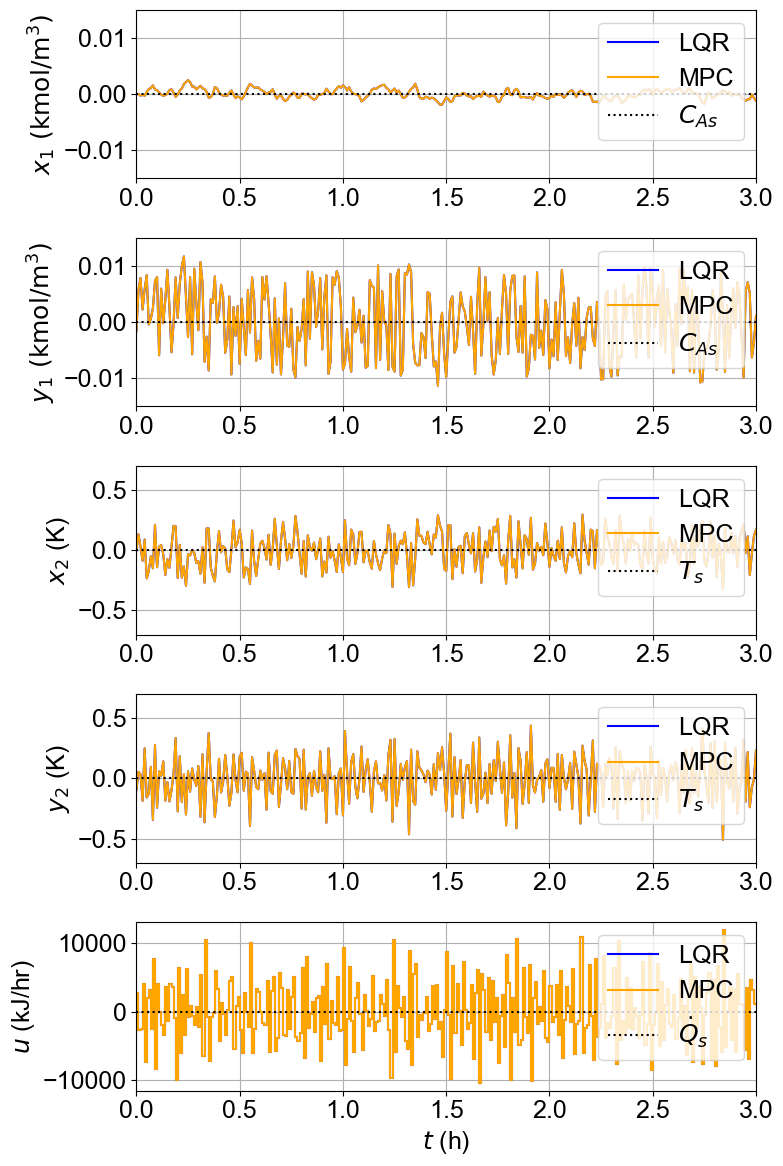

In [54]:
# Plot the results
print(num_steps)
time_steps = np.arange(tot_time+1) * sample_period
print(np.shape(controls))
plt.rcParams.update({'font.size': 18})
plt.rcParams['font.family'] = 'Arial'
fig = plt.figure()

fig.set_figheight(12)
fig.set_figwidth(8)

ax = fig.add_subplot(5, 1, 1)
ax.plot(time_steps[:tot_time+1], states_linear[0,:tot_time+1], label='LQR', color = 'blue') # states_linear[0,:m+2]+CAs
ax.plot(time_steps[:tot_time+1], states[0,:tot_time+1], label='MPC',color='orange')
plt.axhline(0, color='black', label=r'$C_{As}$',linestyle='dotted')
# ax.set_xlabel('Time (hr)')
# ax.set_ylabel('State')
ax.set_ylim([-0.015,0.015])
# ax.set_ylabel('Actual concentration \n' r'$\mathrm{(kmol/m^3)}$')
ax.set_ylabel(r'$x_1 \ \mathrm{(kmol/m^3)}$')
# ax.set_title('State v/s time')
# ax.set_title('State 1 v/s time')
ax.legend(loc="upper right")

ax = fig.add_subplot(5, 1, 3)
ax.plot(time_steps[:tot_time+1], states_linear[1, :tot_time+1], label='LQR', color = 'blue') # states_linear[1, :m+2]+Ts
ax.plot(time_steps[:tot_time+1], states[1, :tot_time+1], label='MPC',color='orange')
plt.axhline(0, color='black', label=r'$T_{s}$',linestyle='dotted')
# ax.set_xlabel('Time (hr)')
ax.set_ylabel(r'$x_2$'' (K)')
ax.set_ylim([-0.7,0.7])
# ax.set_yticks([-0.5,-0.25,0,0.25,0.5])
# ax.set_ylim([-10,10])
ax.legend(loc="upper right")

ax = fig.add_subplot(5, 1, 2)
ax.plot(time_steps[:tot_time+1], output_linear[0,:tot_time+1], label='LQR', color = 'blue')
ax.plot(time_steps[:tot_time+1], output[0,:tot_time+1], label='MPC',color='orange')
plt.axhline(0, color='black', label=r'$C_{As}$',linestyle='dotted')
# ax.set_xlabel('Time (hr)')
# ax.set_ylabel('Output')
# ax.set_title('Output  v/s time')
ax.set_ylim([-0.015,0.015])
ax.set_ylabel(r'$y_1 \ \mathrm{(kmol/m^3)}$')
# ax.set_title('Output 1 v/s time')
ax.legend(loc="upper right")

ax = fig.add_subplot(5, 1, 4)
ax.plot(time_steps[:tot_time+1], output_linear[1, :tot_time+1], label='LQR', color = 'blue')
ax.plot(time_steps[:tot_time+1], output[1, :tot_time+1], label='MPC',color='orange')
plt.axhline(0, color='black', label=r'$T_{s}$',linestyle='dotted')
# ax.set_xlabel('Time (h)')
# ax.set_ylabel('Measured temperature (K)')
ax.set_ylabel(r'$y_2$'' (K)')
# ax.set_ylim([-100,100])
ax.set_ylim([-0.7,0.7])
# ax.set_yticks([-0.5,-0.25,0,0.25,0.5])
# ax.set_ylim([-5,5])
ax.legend(loc="upper right")


ax = fig.add_subplot(5, 1, 5)
ax.step(time_steps[:tot_time+1], controls_linear[0, :tot_time+1], where = 'post', label = 'LQR', color = 'blue')
ax.step(time_steps[:tot_time+1], controls[0, :tot_time+1], where = 'post', label = 'MPC',color='orange')
plt.axhline(0, color='black', label=r'$\dot{Q}_{s}$',linestyle='dotted')
ax.set_xlabel(r'$t$'' (h)')
# ax.set_ylabel('Control Input')
ax.set_ylabel(r'$u$'' (kJ/hr)')
# ax.set_title('Input v/s time')
ax.legend(loc="upper right")

# ax = fig.add_subplot(4, 2, 6)
# ax.plot(time_steps[:m+2], tot_cost_linear[:m+2], label = 'Explicit controller', color = 'blue')
# ax.plot(time_steps[:n+2], tot_cost_MPC[:n+2], label = 'MPC',color='orange')
# ax.set_xlabel('Time (hr)')
# ax.set_ylabel('Cost')
# ax.set_title('Cost v/s time')
# ax.legend()

# ax = fig.add_subplot(4, 2, 7)
# # ax.plot(time_steps[:m+2], norm[:m+2], label = 'Explicit controller', color = 'blue')
# # ax.plot(time_steps[:n+2], norm[:n+2], label = 'MPC',color='orange')
# ax.set_xlabel('Time (hr)')
# ax.set_ylabel(r'$\mathrm{Rate(kmol/m^3hr)}$')
# ax.set_title('Rate v/s time')
# ax.legend()

# ax = fig.add_subplot(4, 2, 8)
# ax.plot(time_steps[:m+2], dist_linear[0,:m+2], label = 'Explicit controller', color = 'blue')
# ax.plot(time_steps[:n+2], dist_MPC[0,:n+2], label = 'MPC',color='orange')
# ax.set_xlabel('Time (hr)')
# # ax.set_ylabel('Disturbance')
# # ax.set_title('Disturbance v/s time')
# ax.set_ylabel(r'$\mathrm{Disturbance(kmol/m^3)}$')
# ax.set_title('Disturbance in Concentration v/s time')
# ax.legend()

# ax = fig.add_subplot(4, 2, 6)
# ax.plot(time_steps[:n+2], dist_linear[2,:n+2], label = 'Explicit controller', color = 'blue')
# ax.plot(time_steps[:n+2], dist_MPC[2,:n+2], label = 'MPC',color='orange')
# ax.set_xlabel('Time (hr)')
# # ax.set_ylabel('Noise')
# # ax.set_title('Noise v/s time')
# ax.set_ylabel(r'$\mathrm{Disturbance(kmol/m^3)}$')
# ax.set_title('Disturbance in Concentration v/s time')
# ax.legend()

fig.tight_layout()
for axis in fig.get_axes():
    axis.grid(True)

# for axis in fig.axes:
#     axis.set_xlim([0,(m+1)*dt])
# for axis in fig.axes:
#     axis.set_ylim([-1e5,1e5])
for axis in fig.axes:
# # #     axis.set_xlim([0,(m+1)*dt])
    axis.set_xlim([0,3])
plt.show()